In [5]:
import tensorflow as tf
import os
import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- TFRecord Paths ---
base_tfrecords_zip_dir = r"C:\Users\Naman Rajput\Desktop\Exodec\pre-processing\Tfrecords_zip"
train_dir = os.path.join(base_tfrecords_zip_dir, "train")
val_dir = os.path.join(base_tfrecords_zip_dir, "validate")

# --- Feature Description ---
feature_description = {
    "local view": tf.io.FixedLenFeature([81], tf.float32, default_value=[0.0]*81),
    "global view": tf.io.VarLenFeature(tf.float32),
    "odd_even view": tf.io.VarLenFeature(tf.float32),
    "shifted global view": tf.io.FixedLenFeature([201], tf.float32, default_value=[0.0]*201),
    "Disposition": tf.io.FixedLenFeature([], tf.string, default_value=b"")
}

# ---TFRecord Parsing Function ---
def parse_tfrecord_fn(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # --- Handling Fixed-Length Features ---
    local_view = tf.expand_dims(parsed_features['local view'], -1)
    shifted_view = tf.expand_dims(parsed_features['shifted global view'], -1)
    label = tf.cast(tf.equal(parsed_features["Disposition"], b"PC"), tf.float32)

    # --- function for variable-length features ---
    def process_varlen_feature(feature, target_len):
        # Accessing the sparse tensor's values
        tensor = feature.values
        
        # Reshape to a defined shape, empty tensor handling
        tensor = tf.reshape(tensor, [-1]) # Ensure it's a 1D tensor
        
        # truncate to the target length
        current_len = tf.shape(tensor)[0]
        paddings = [[0, target_len - current_len]]
        tensor = tf.pad(tensor, paddings, "CONSTANT", constant_values=0.0)
        tensor = tensor[:target_len]
        
        # Set a static shape for the model
        tensor = tf.reshape(tensor, [target_len, 1])
        return tensor

    global_view = process_varlen_feature(parsed_features['global view'], 201)
    odd_even_view = process_varlen_feature(parsed_features['odd_even view'], 162)

    inputs = {
        'local': local_view,
        'global': global_view,
        'odd_even': odd_even_view,
        'shifted': shifted_view,
    }
    return inputs, label

# --- Dataset Loader ---
def create_tf_dataset(data_dir, batch_size=32, shuffle_buffer_size=1000, is_training=True):
    tfrecord_files = glob.glob(os.path.join(data_dir, "**", "*.tfRecords"), recursive=True)
    
    if not tfrecord_files:
        print(f"Warning: No TFRecord files found in '{data_dir}'.")
        return None

    dataset = tf.data.TFRecordDataset(tfrecord_files, num_parallel_reads=tf.data.AUTOTUNE)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.ignore_errors() 

    if is_training:
        dataset = dataset.shuffle(shuffle_buffer_size)
        dataset = dataset.repeat()

    # drop_remainder=True to ensure all batches have the same size.
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# --- CNN Model ---
def build_cnn_model():
    def conv_branch(input_shape, name):
        input_layer = Input(shape=input_shape, name=name)
        x = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_layer)
        x = MaxPooling1D(2, padding='same')(x)
        x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
        x = MaxPooling1D(2, padding='same')(x)
        x = Flatten()(x)
        return input_layer, x

    view_shapes = {
        'local': (81, 1),
        'global': (201, 1),
        'odd_even': (162, 1),
        'shifted': (201, 1)
    }

    input_layers = {}
    branch_outputs = []

    for name, shape in view_shapes.items():
        input_layer, output = conv_branch(shape, name)
        input_layers[name] = input_layer
        branch_outputs.append(output)

    x = Concatenate(name='concatenated_features')(branch_outputs)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid', name='exoplanet_probability')(x)

    model = Model(inputs=input_layers, outputs=output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- Utility to count records---
def count_records(file_paths):
    count = 0
    for fn in file_paths:
        for _ in tf.data.TFRecordDataset(fn).ignore_errors():
            count += 1
    return count

# --- Main Execution Block ---
if __name__ == '__main__':
    model = build_cnn_model()
    model.summary()

    BATCH_SIZE = 64
    SHUFFLE_BUFFER = 2000

    train_ds = create_tf_dataset(train_dir, BATCH_SIZE, SHUFFLE_BUFFER, is_training=True)
    val_ds = create_tf_dataset(val_dir, BATCH_SIZE, is_training=False)

    if not train_ds:
        print("CRITICAL ERROR: Training dataset could not be created. Exiting.")
        exit()

    train_files = glob.glob(os.path.join(train_dir, "**", "*.tfRecords"), recursive=True)
    val_files = glob.glob(os.path.join(val_dir, "**", "*.tfRecords"), recursive=True)

    count_train = count_records(train_files)
    count_val = count_records(val_files)

    print(f"\nFound {count_train} training examples.")
    print(f"Found {count_val} validation examples.")
    
    if count_train == 0:
        print("ERROR: No examples found in training dataset. Training cannot proceed.")
        exit()

    steps_per_epoch_train = count_train // BATCH_SIZE
    validation_steps_val = count_val // BATCH_SIZE if count_val > 0 else 0

    history = model.fit(
        train_ds,
        epochs=10,
        steps_per_epoch=steps_per_epoch_train,
        validation_data=val_ds,
        validation_steps=validation_steps_val,
        verbose=1
    )


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ local (InputLayer)            │ (None, 81, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global (InputLayer)           │ (None, 201, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ odd_even (InputLayer)         │ (None, 162, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ shifted (InputLayer)          │ (None, 201, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_24 (Conv1D)            │ (None, 81, 32)            │             192 │ local[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_26 (Conv1D)            │ (None, 201, 32)           │             192 │ global[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_28 (Conv1D)            │ (None, 162, 32)           │             192 │ odd_even[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_30 (Conv1D)            │ (None, 201, 32)           │             192 │ shifted[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_24              │ (None, 41, 32)            │               0 │ conv1d_24[0][0]            │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_26              │ (None, 101, 32)           │               0 │ conv1d_26[0][0]            │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_28              │ (None, 81, 32)            │               0 │ conv1d_28[0][0]            │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_30              │ (None, 101, 32)           │               0 │ conv1d_30[0][0]            │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_25 (Conv1D)            │ (None, 41, 64)            │           6,208 │ max_pooling1d_24[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_27 (Conv1D)            │ (None, 101, 64)           │           6,208 │ max_pooling1d_26[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_29 (Conv1D)            │ (None, 81, 64)            │           6,208 │ max_pooling1d_28[0][0]     │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,377,537 (5.25 MB)

 Trainable params: 1,377,537 (5.25 MB)

 Non-trainable params: 0 (0.00 B)


Found 5230 training examples.
Found 640 validation examples.
Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step - accuracy: 0.9522 - loss: 0.2668 - val_accuracy: 0.8406 - val_loss: 0.1866
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9634 - loss: 0.1656 - val_accuracy: 0.8406 - val_loss: 0.1755
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.9632 - loss: 0.1520 - val_accuracy: 0.8406 - val_loss: 0.1866
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9588 - loss: 0.1641 - val_accuracy: 0.8406 - val_loss: 0.1711
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9620 - loss: 0.1328 - val_accuracy: 0.8406 - val_loss: 0.1815
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9612 - loss: 0.1475 - val_accuracy: 0.8406 - val_loss: 0.1669
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9592 - loss: 0.1412 - val_accuracy: 0.8406 - val_loss: 0.1706
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/s


--- Plotting Training and Validation Metrics ---


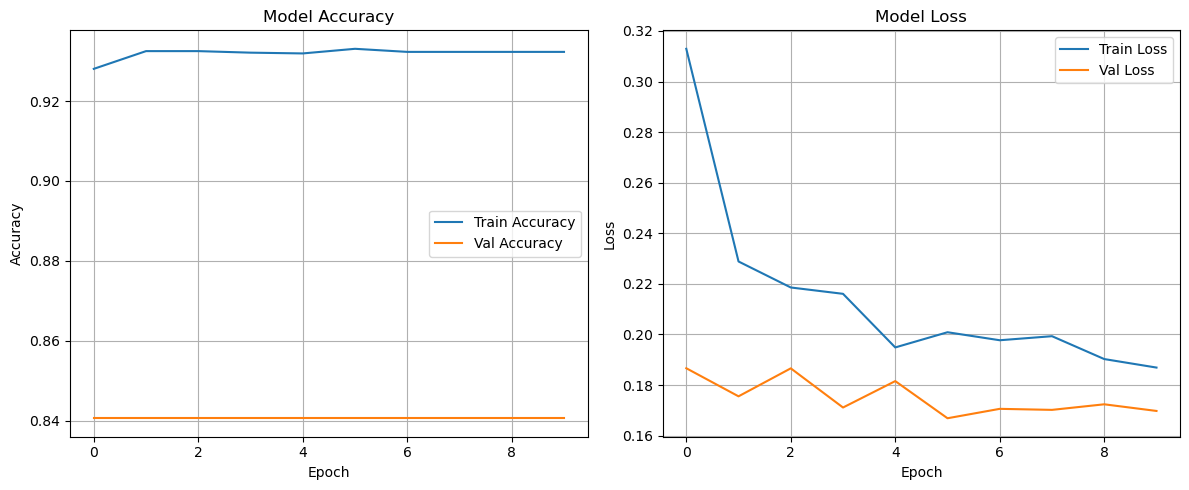

In [10]:
if history and history.history:
        print("\n--- Plotting Training and Validation Metrics ---")
        plt.figure(figsize=(12, 5))

        # Plot Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)

        # Plot Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
else:
        print("\nTraining history is not available. Cannot plot metrics.")
